<a href="https://colab.research.google.com/github/mahmayer/Mackenzie/blob/main/Linguagem_natural_Articulistas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##UNIVERSIDADE PRESBITERIANA MACKENZIE
##ESPECIALIZAÇÃO EM CIÊNCIA DE DADOS (BIG DATA PROCESSING AND ANALYTICS)
##RECUPERAÇÃO DA INFORMAÇÃO NA WEB E EM REDES SOCIAIS

*Mayara Mayer Candia Marques*

##**Processamento de Linguagem Natural: extração de palavras-chave - Articulistas UOL**

###**1. Introdução**
Este trabalho tem o objetivo de mostrar o processamento de linguagem natural com a extração de palavras-chave de uma lista de artigos de diversos blogueiros do site de notícias UOL. 

### **2. Importação dos dados**
Primeiramente, foram importadas todas as bibliotecas necessárias do Python e o arquivo no formato 'json' contendo os dados a serem analisados.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import re
import unicodedata
from unidecode import unidecode
import string
import collections
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.collocations import *
from nltk import FreqDist
from nltk.util import ngrams    

In [ ]:
data = pd.read_json('https://raw.githubusercontent.com/mahmayer/articulistas/main/UolBlogs.json')

titles = data[['author','title']].copy()
titles.head(10)

,author,title
0,Josias de Souza,Fantasia de sheik do Zero Três é extravagância...
1,Ricardo Kotscho,"Com medo do relatório da CPI, Bolsonaro chora ..."
2,Josias de Souza,Trombada com o PT faz parte do projeto de Ciro
3,Kennedy Alencar,"Se tivessem vergonha na cara, Guedes e Campos ..."
4,Josias de Souza,"Bolsonaro deveria privatizar a si mesmo, renun..."
5,Josias de Souza,"Chance de TSE cassar Bolsonaro, que já era imp..."
6,Reinaldo Azevedo,Os senadores responsáveis da CPI não podem se ...
7,Josias de Souza,'Choro' de Bolsonaro derruba lágrimas cenográf...
8,Josias de Souza,CPI indicia Bolsonaro e Lira diz ao STF que im...
9,Josias de Souza,Entrevista de Aras tem aparência de strip-tease


#### **2.1. Primeira Nuvem de Palavras**
Em seguida, foi gerada a primeira nuvem de palavras antes do pré-tratamento.

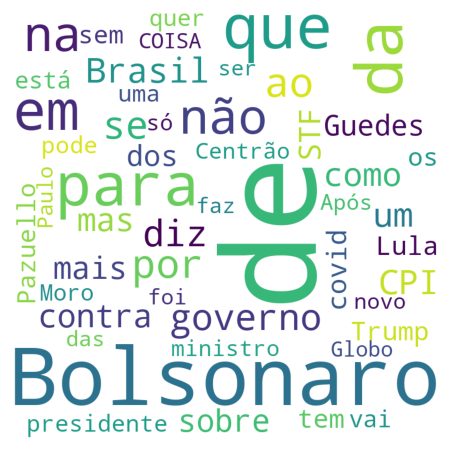

In [ ]:
original_text = ' '.join(titles['title'])

wordcloud1 = WordCloud(collocations=False, normalize_plurals=False, stopwords=None, width=800, height=800, background_color='white', min_font_size = 10, max_words=50).generate(original_text)
                    
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud1)
plt.axis("off")
plt.show()

### **3. Pré-tratamento**
Nessa etapa, foram feitos os pré-tratamentos necessários. 

Primeiramente, foi importado a função de singularização.

In [ ]:
"""
Thanks for https://simasware.wordpress.com/2014/02/28/pluralizacao-em-pt-br-rails/
"""

INVARIAVEL = [  'lápis',
                'atlas',
                'pires',
                'ônibus',
                'vírus',
                'bônus',
                'ônus',
                'cais',
                'xis',
                'óculos',
                'ourives',
                'parabéns',
                'atras',
                'frances',
                'ingles',

            ]
def transliterate(string: str) -> str:
    # Copy from inflection Library https://github.com/jpvanhal/inflection
    """
    Replace non-ASCII characters with an ASCII approximation. If no
    approximation exists, the non-ASCII character is ignored. The string must
    be ``unicode``.
    Examples::
        >>> transliterate('älämölö')
        'alamolo'
        >>> transliterate('Ærøskøbing')
        'rskbing'
    """
    normalized = unicodedata.normalize('NFKD', string)

    return normalized.encode('ascii', 'ignore').decode('ascii')

def singularizar(PalavraOriginal):
    """ Remove acentos e deixa tudo minuscula"""
    palavra = PalavraOriginal.lower()

    for wd in INVARIAVEL:
        if transliterate(wd).lower() == palavra:
            return palavra

    """      Lista de regras, composto em tuplas de valor a ser buscado e regra de substituição    """
    rules = []

    """    Palavras terminadas em ns    """
    rules.append((r"^([a-zA-z]*)ns$", r"\1m"))

    """ Palavras terminas em r ou z luzes - luz, flores - flor, arrozes - arroz"""
    rules.append((r"^([a-zA-z]*)res$", r"\1r"))
    rules.append((r"^([a-zA-z]*)zes$", r"\1z"))
    rules.append((r"^([a-zA-z]*)ses$", r"\1s"))

    """    Palavras terminadas em ão    """
    rules.append((r"^([a-zA-z]*)oes$", r"\1ao"))
    rules.append((r"^([a-zA-z]*)aos$", r"\1ao"))
    rules.append((r"^([a-zA-z]*)aes$", r"\1ao"))

    """ Palavras regulares, casos simples: carros, arvores, aboboras"""
    rules.append((r"^([a-zA-z]*)(a|e|o|u)is$", r"\1\2l"))

    """ Palavras terminas em il  cantis - cantil """
    rules.append((r"^([a-zA-z]*)is$", r"\1il"))

    """ Palavras terminas em les  mal - males, mel - meles """
    rules.append((r"^([a-zA-z]*)les$", r"\1l"))


    """ Palavras regulares, casos simples: carros, arvores, aboboras"""
    rules.append((r"^([a-zA-z]*)(a|e|i|o|u)s$", r"\1\2"))
    
    for rule in rules:
        if re.match(rule[0], palavra) is not None:
            return re.sub(rule[0], rule[1], palavra, 1, re.IGNORECASE)
    return palavra

Em seguida, transformou-se todas as letras em minúscula, removeu-se os acentos, a pontuação, os números, as palavras de parada e os plurais.

In [ ]:
nltk.download('stopwords')
stop = stopwords.words('portuguese')

titles['title_treated'] = titles['title'].str.lower().apply(lambda x: unidecode(x))
titles['title_treated'] = titles['title_treated'].str.replace('[{}]'.format(string.punctuation), '')
titles['title_treated'] = titles['title_treated'].str.replace('[{}]'.format(string.digits), '')
titles['title_treated'] = titles['title_treated'].str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
titles['title_treated'] = titles['title_treated'].apply(lambda x: ' '.join([singularizar(word) for word in x.split()]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### **4. Resultado**
#### **4.1. Tabela**
A tabela a seguir apresenta as 10 palavras mais frequentes nos artigos com sua respectiva quantidade.

In [ ]:
#cria uma lista com todos os tokens
nltk.download('punkt')

big_line = ' '.join(sent for sent in titles['title_treated'])
tokens = word_tokenize(big_line)
df = nltk.FreqDist(tokens)
df = sorted(df.items(), key=lambda x: x[1], reverse=True)
freq = pd.DataFrame.from_dict(df)
n = 0
display(freq.iloc[n:n+10])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,0,1
0,bolsonaro,1673
1,nao,565
2,diz,299
3,governo,299
4,brasil,265
5,cpi,249
6,contra,218
7,sobre,206
8,stf,185
9,guede,176


#### **4.2. Nuvem de palavras**
Após o pré-tratamento tem-se uma nova nuvem de palavras, com 50 termos mais significativos.

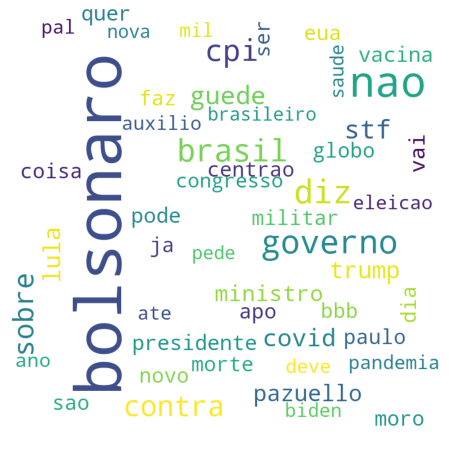

In [ ]:
treated_text = ' '.join(titles['title_treated'])

wordcloud2 = WordCloud(collocations=False, normalize_plurals=False, stopwords=None, width=800, height=800, background_color='white', min_font_size = 10, max_words=50).generate(treated_text)
                       
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud2)
plt.axis("off")
plt.show()

### **5. Bigramas**
Nesta etapa do trabalho foi feito o tratamento por bigramas, ou seja, tokenização por um par de palavras subsequentes, para ver como ficava a frequência de termos com esse tratamento.

In [ ]:
bigram = nltk.FreqDist(nltk.bigrams(word_tokenize(treated_text)))
sorted_bgm = sorted(bigram.items(), key=lambda x: x[1], reverse=True)
tokens_bigram = dict((' '.join(text), count) for text, count in sorted_bgm)

Após tratamento tem-se uma tabela com os 10 bigramas mais frequentes e uma nova nuvem de palavra formada com 50 principais bigramas.

In [ ]:
treated_text = ' '.join(titles['title_treated'])

tokens = word_tokenize(treated_text)
bigram_tokens = nltk.bigrams(tokens)
bigram_fd = nltk.FreqDist(bigram_tokens)
sorted_bgm = sorted(bigram_fd.items(), key=lambda x: x[1], reverse=True)
pd_bigram_df = pd.DataFrame.from_dict(sorted_bgm)

pd_bigram_df.head(10)

,0,1
0,"(lava, jato)",45
1,"(bolsonaro, nao)",45
2,"(sao, paulo)",44
3,"(rodrigo, maia)",36
4,"(paulo, guede)",33
5,"(cpi, covid)",33
6,"(auxilio, emergencial)",30
7,"(governo, bolsonaro)",29
8,"(fake, news)",29
9,"(bolsonaro, bolsonaro)",28


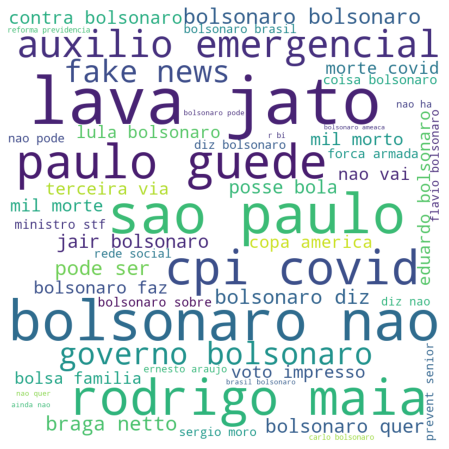

In [ ]:
wordcloud3 = WordCloud(collocations=False, normalize_plurals=False, stopwords=None, width=800, height=800, background_color='white', min_font_size = 10, max_words=50).generate_from_frequencies(tokens_bigram)
                    
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud3)
plt.axis("off")
plt.show()